In [43]:
import torch
from transformers import CLIPProcessor, CLIPModel
import glob
from PIL import Image
from hdbscan import HDBSCAN
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import normalize
from sentence_transformers import SentenceTransformer, util

In [3]:
img_model = SentenceTransformer('clip-ViT-B-32')
text_model = SentenceTransformer('sentence-transformers/clip-ViT-B-32-multilingual-v1')

modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

C:\Users\Sandra\Desktop\Work\Design\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Sandra\.cache\huggingface\hub\models--sentence-transformers--clip-ViT-B-32. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

C:\Users\Sandra\Desktop\Work\Design\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Sandra\.cache\huggingface\hub\models--sentence-transformers--clip-ViT-B-32-multilingual-v1. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/572 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/371 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.57M [00:00<?, ?B/s]

In [9]:
image_paths = sorted(glob.glob("./images/*"))

def load_image(path):
    return Image.open(path).convert("RGB")  # use path argument

images = [load_image(img_path) for img_path in image_paths]

img_embeddings = img_model.encode(images, convert_to_tensor=True)
print("Image embeddings shape:", img_embeddings.shape)

Image embeddings shape: torch.Size([270, 512])


In [10]:
csv = "powerpoint_data.csv"
df_text = pd.read_csv(csv)

all_texts = []

for _, row in df_text.iterrows():
    all_texts.append(row.get('fixed body', ''))
    all_texts.append(row.get('waiting body', ''))
    all_texts.append(row.get('not fixed body', ''))
    
text_embeddings = text_model.encode(all_texts, convert_to_tensor=True)
print("Text embeddings shape:", text_embeddings.shape)

Text embeddings shape: torch.Size([270, 512])


In [44]:
cos_sim = util.cos_sim(text_embeddings, img_embeddings)

for text, scores in zip(all_texts, cos_sim):
    max_img_idx = torch.argmax(scores)
    print("Text:", text)
    print("Score:", scores[max_img_idx] )
    print("Path:", image_paths[max_img_idx], "\n")

Text: Da min farfar døde, arvede jeg hans teaktræsmoduler til at bygge en sofa samt lænestol. Følgende havde været brugt i mange år, og flere dele var derfor ødelagte. For at sætte sofaen i stand, sleb jeg træet og gav det nyt olie. Herudover købte jeg koldskum til nye hynder, som min mor hjalp mig med at sy betræk til. Desuden blev der også sat nye gjorde i bunden, da flere af de gamle sad løst eller var knækket.​
Score: tensor(0.2786)
Path: ./images\group13_62_Julie_2.png 

Text: Jeg er i øjeblikket ved at sætte nogle gamle arkitekttegnet konferencestole i stand, så de kan bruges som spisebordsstole. Her behandles træet, skruerne bliver udskiftet og hynderne får nyt skum og betræk.
Score: tensor(0.3005)
Path: ./images\group16_77_Emma_Roesen_Madsen_3.jpg 

Text: Jeg fik foræret nogle gamle vinglas, men i fragten til Aalborg knækkede en af dem i stilken. Følgende har jeg valgt ikke at reparere, da jeg har flere af samme glas, mens man også stadig vil kunne se skaden, hvis det blev lime

In [11]:
all_texts[0]

'Da min farfar døde, arvede jeg hans teaktræsmoduler til at bygge en sofa samt lænestol. Følgende havde været brugt i mange år, og flere dele var derfor ødelagte. For at sætte sofaen i stand, sleb jeg træet og gav det nyt olie. Herudover købte jeg koldskum til nye hynder, som min mor hjalp mig med at sy betræk til. Desuden blev der også sat nye gjorde i bunden, da flere af de gamle sad løst eller var knækket.\u200b'

In [12]:
image_paths[0]

'./images\\group01_0_Josephine_1.jpg'

In [29]:
normalized_embeddings = normalize(img_embeddings, norm="l2")

In [30]:
clusterer = HDBSCAN(
    min_cluster_size=5,
    min_samples=3
    #metric='precomputed' did not change the clusters
)
cluster_labels = clusterer.fit_predict(normalized_embeddings)

C:\Users\Sandra\Desktop\Work\Design\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Sandra\Desktop\Work\Design\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


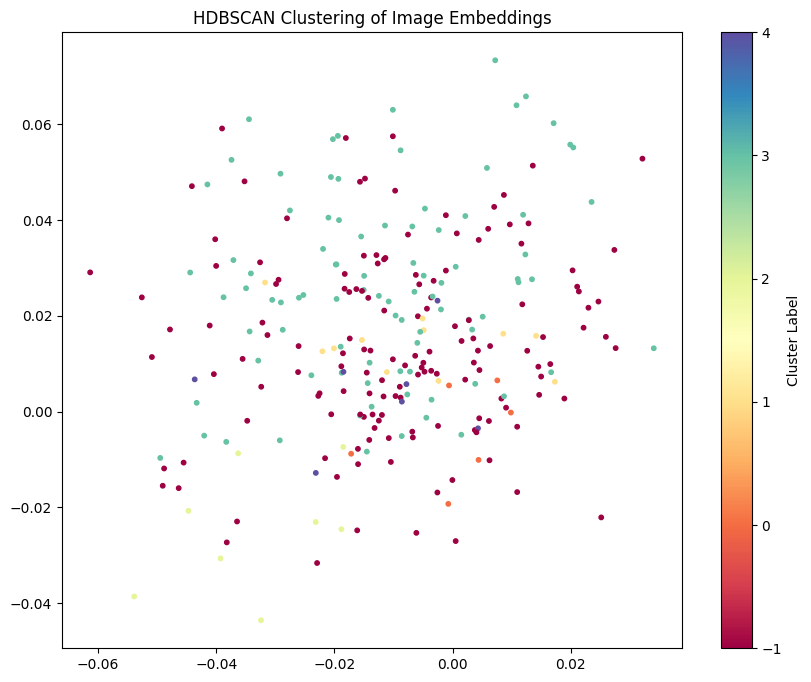

In [21]:
plt.figure(figsize=(10, 8))
plt.scatter(
    normalized_embeddings[:, 0],
    normalized_embeddings[:, 1],
    c=cluster_labels,
    cmap='Spectral',
    s=10
)
plt.colorbar(label='Cluster Label')
plt.title('HDBSCAN Clustering of Image Embeddings')
plt.show()


In [31]:
df = pd.DataFrame({
    "image": image_paths,
    "cluster": cluster_labels
})

print(df["cluster"].value_counts())

cluster
 0    168
-1     96
 1      6
Name: count, dtype: int64


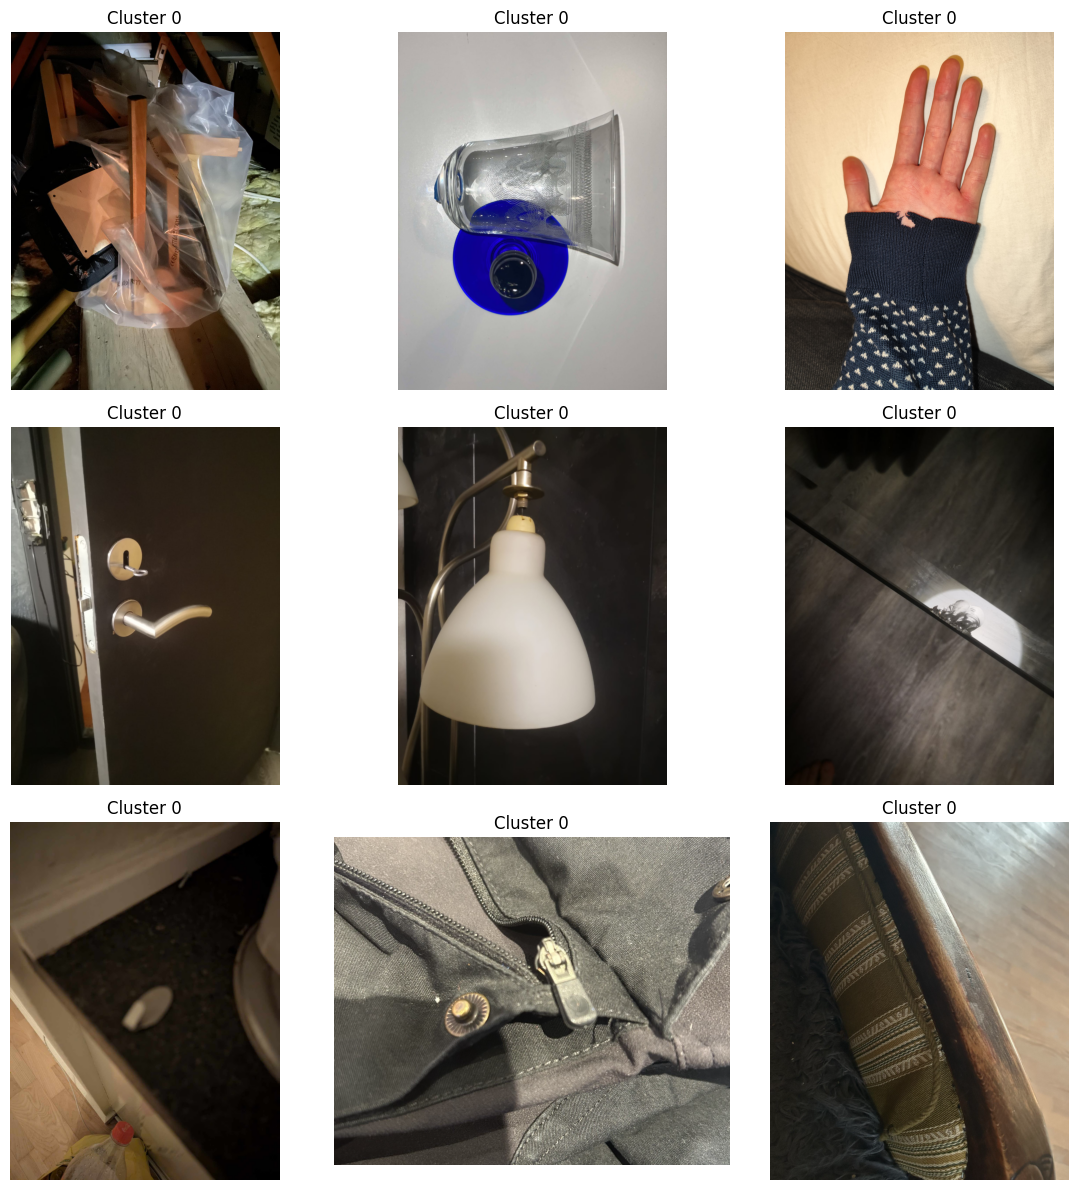

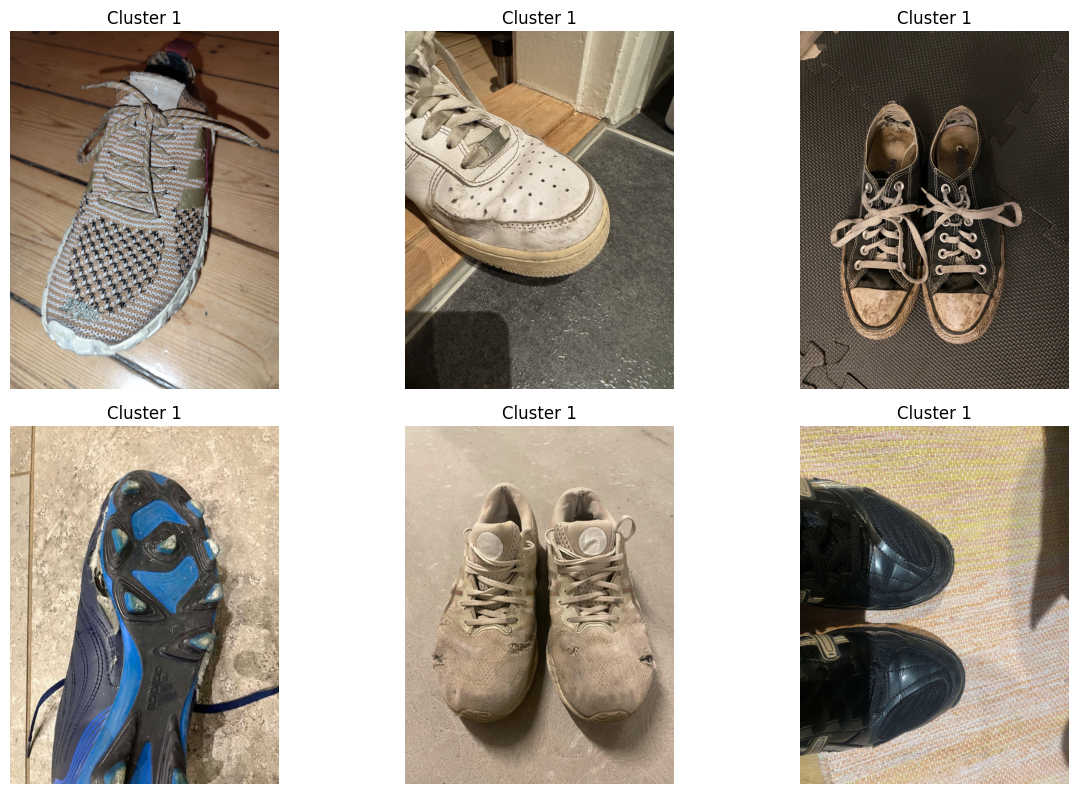

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

In [32]:
def show_cluster_images(cluster_number, n=9):
    paths = [path for path, label in zip(image_paths, cluster_labels) if label == cluster_number]
    sample_paths = paths[:n]

    plt.figure(figsize=(12, 12))
    for i, img_path in enumerate(sample_paths):
        plt.subplot(3, 3, i+1)
        img = Image.open(img_path)
        plt.imshow(img)
        plt.title(f"Cluster {cluster_number}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_cluster_images(0)
show_cluster_images(1)
show_cluster_images(2)
show_cluster_images(3)
show_cluster_images(4)


In [34]:
num_clusters = df["cluster"].nunique() - (1 if -1 in df["cluster"].values else 0)
print(f"Number of clusters: {num_clusters}")

Number of clusters: 2


In [36]:
image_np = img_embeddings.cpu().numpy()
text_np = text_embeddings.cpu().numpy()

combined_embeddings = (image_np + text_np) / 2

In [37]:
normalized_embeddings2 = normalize(combined_embeddings, norm='l2')

In [38]:
cluster_labels2 = clusterer.fit_predict(normalized_embeddings2)

C:\Users\Sandra\Desktop\Work\Design\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Sandra\Desktop\Work\Design\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


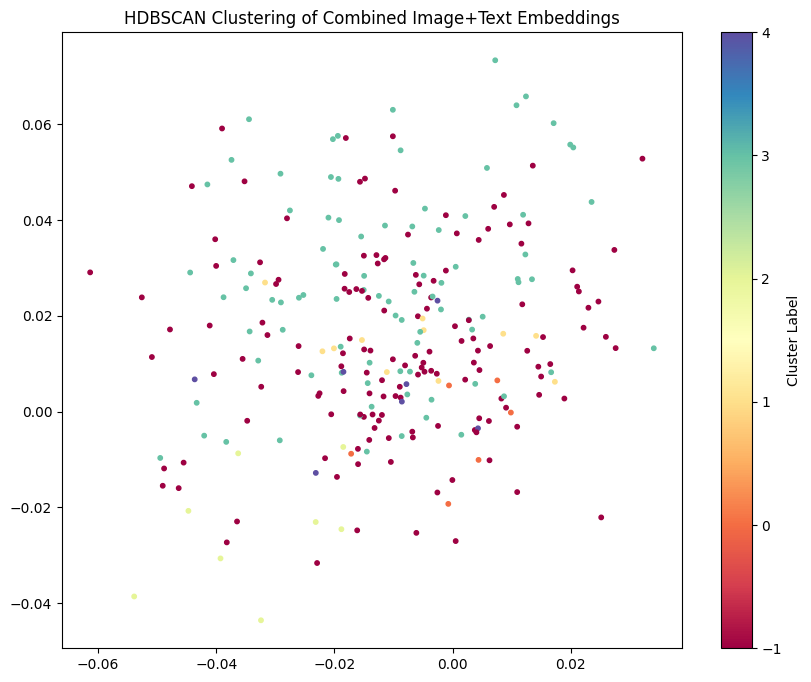

In [39]:
plt.figure(figsize=(10, 8))
plt.scatter(
    normalized_embeddings2[:, 0], normalized_embeddings2[:, 1],
    c=cluster_labels2,
    cmap='Spectral',
    s=10
)
plt.colorbar(label='Cluster Label')
plt.title('HDBSCAN Clustering of Combined Image+Text Embeddings')
plt.show()

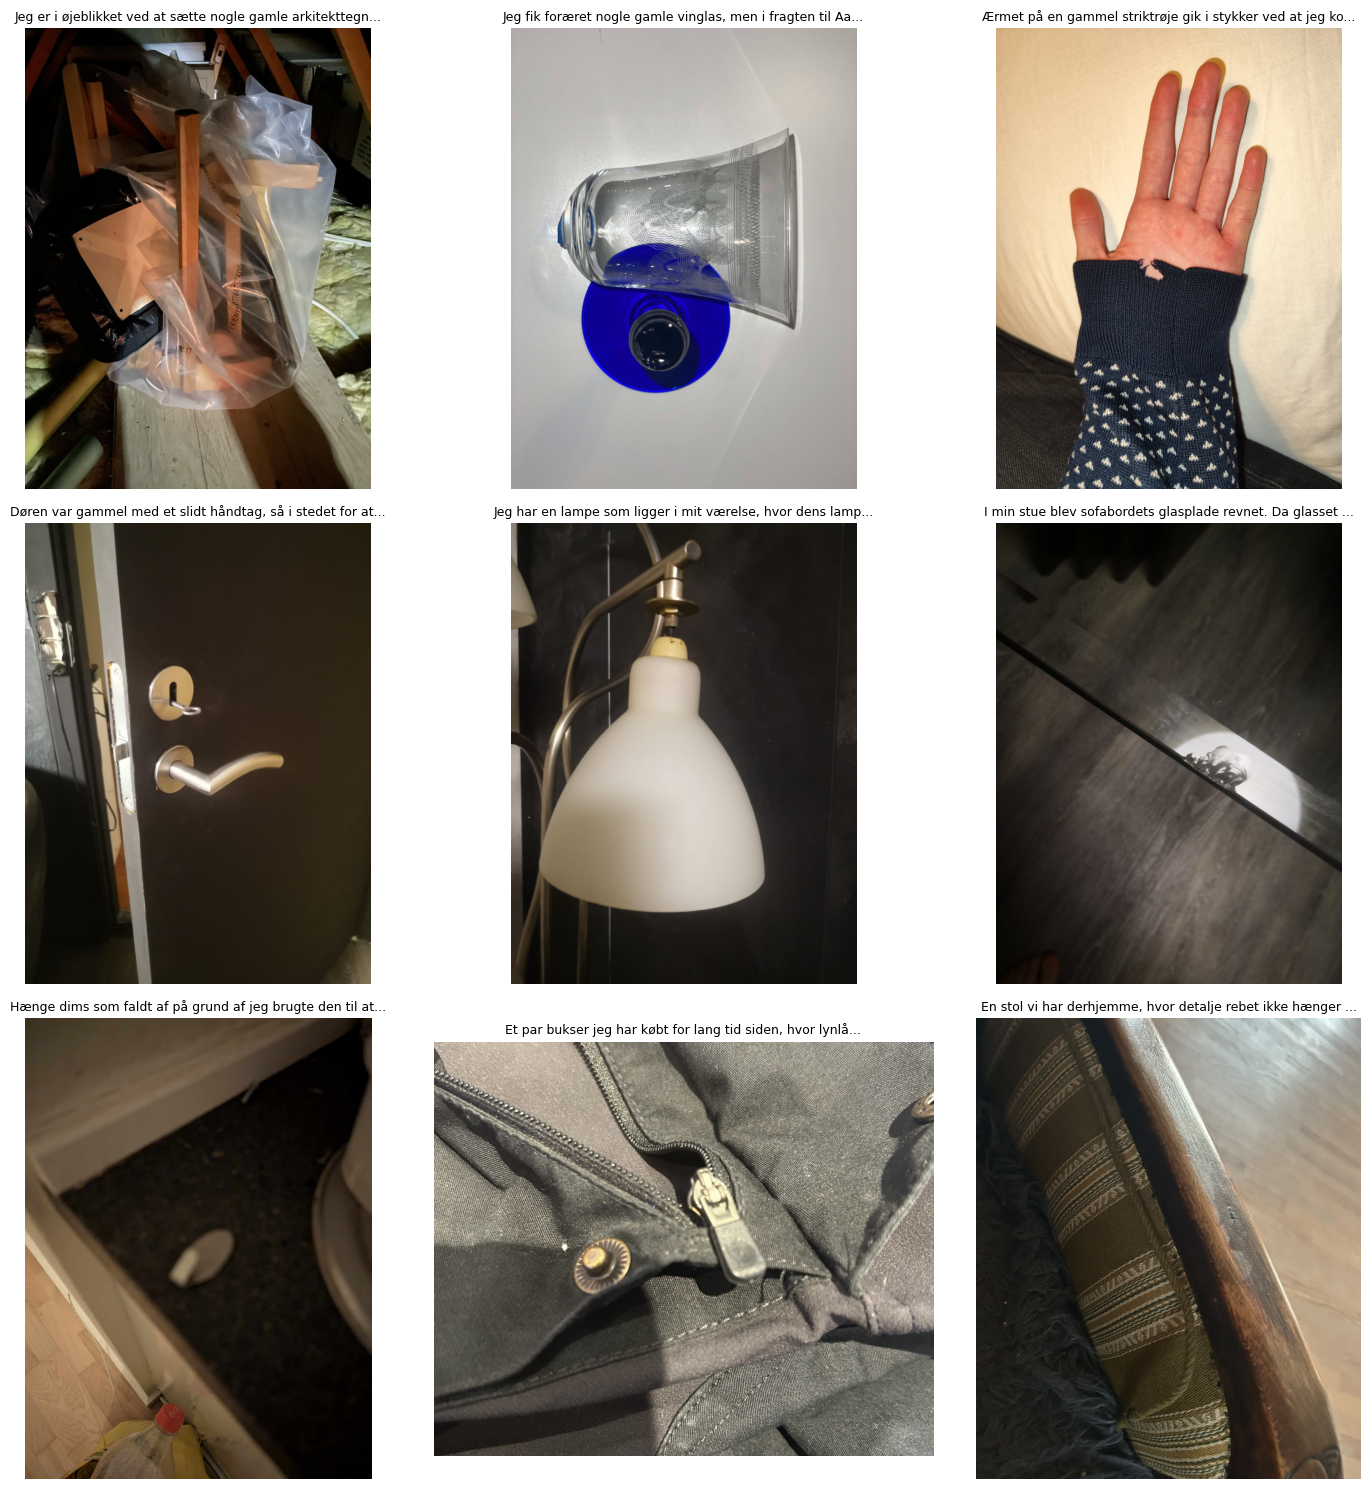

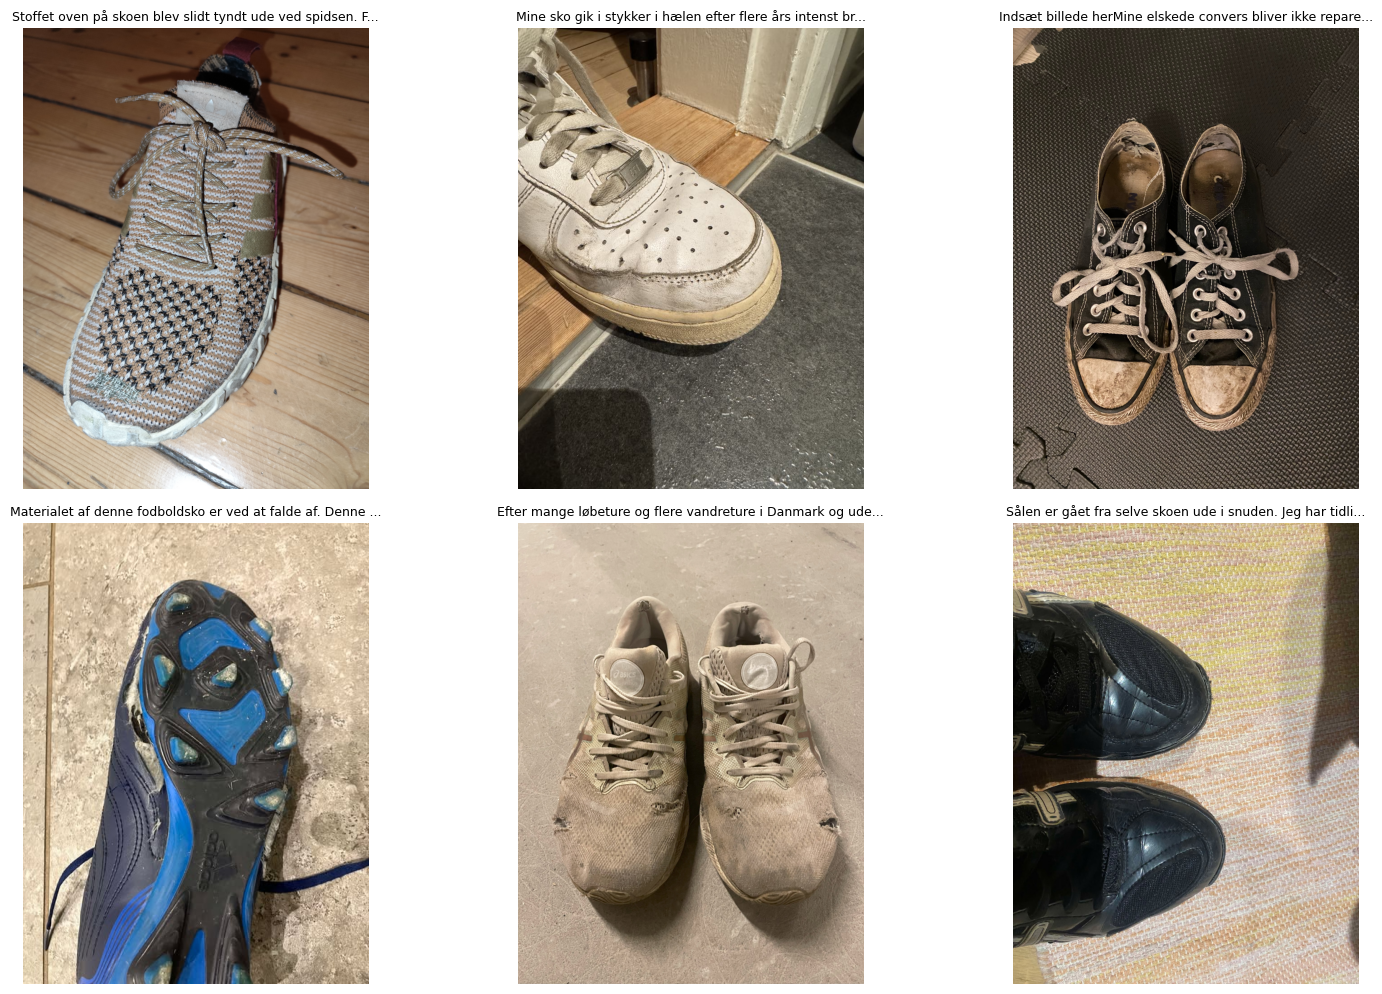

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

In [40]:
def show_cluster_images_with_text(cluster_number, n=9):
    filtered = [(path, txt) for path, txt, label in zip(image_paths, all_texts, cluster_labels) if label == cluster_number]
    sample = filtered[:n]

    plt.figure(figsize=(15, 15))
    for i, (img_path, txt) in enumerate(sample):
        plt.subplot(3, 3, i + 1)
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis('off')
        display_text = txt if len(txt) < 60 else txt[:57] + "..."
        plt.title(display_text, fontsize=9)

    plt.tight_layout()
    plt.show()

for cnum in range(8):
    show_cluster_images_with_text(cnum)

In [42]:
ari = adjusted_rand_score(cluster_labels, cluster_labels2)
nmi = normalized_mutual_info_score(cluster_labels, cluster_labels2)
print(ari)
print(nmi)

0.21683237061907729
0.35724045340102
